## Warming Up with JAX

- JAX is a library for array-oriented numerical computation (like Numpy) <br>
- It comes with Automatic Differentiation and Just-In-Time Compilation <br>
- This enables high performance machine learning research

- JAX's syntax (for the most part) is just like NumPy's

In [2]:
import jax.numpy as jnp
import numpy as np

- JAX has special transform functions

In [3]:
from jax import grad, jit, vmap, pmap

- JAX's low level API

In [5]:
from jax import lax
# lax is just anagram for XLA

In [18]:
import matplotlib.pyplot as plt
import jax.random

### Very Similar to NumPy

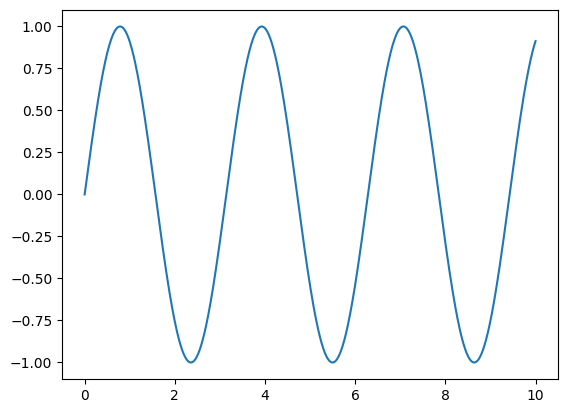

In [9]:
# Create 1000 datapoints from 0 to 10
x_np = np.linspace(0, 10, 1000)
# Create a function
y_np = 2*np.sin(x_np)*np.cos(x_np)
# Plot the function
plt.plot(x_np, y_np)

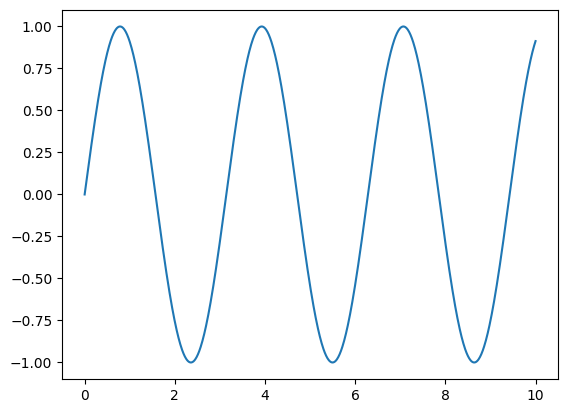

In [11]:
# Create 1000 datapoints from 0 to 10 using JAX
x_jnp = jnp.linspace(0, 10, 1000)
# Create a function using JAX
y_jnp = 2*jnp.sin(x_np)*jnp.cos(x_np)
# Plot the function
plt.plot(x_jnp, y_jnp)

### JAX Arrays are Immutable

In [12]:
size = 10
index = 0
val = 23

In [13]:
print("NumPy Array")
x = np.arange(size)
print(x)
x[index] = val
print(x)

NumPy Array
[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [14]:
print("JAX Array")
x = jnp.arange(size)
print(x)
x[index] = val
print(x)

JAX Array
[0 1 2 3 4 5 6 7 8 9]


TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html

### Solution to edit JAX arrays

In [15]:
x = jnp.arange(size)
print(x)
y = x.at[index].set(val)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


### JAX handles random number generation very differently (for a good reason)

In [24]:
seed = 0
key = jax.random.PRNGKey(seed)
# Key is just fancy way of creating a "state"
# Pseudo-random Number Generators(PRNG) are "stateful"
# JAX is not.
# Why? -> Consequence of Functional Programming
# "Stateful" -> It maintains an internal state that is updated each time a new "random" number
#               is produced. The entire sequence of numbers generated depends on this internal
#               state and it's initial value (also known as the "seed")
# This state makes PRNGs deterministic and reproducible
# Rather than relying on a hidden, global state like NumPy, JAX requires the user to explicitly
# manage and pass a "key" -> Aligns with JAX's principle of Func Programming

In [26]:
# Sample 10 random numbers from a normal distribution
x = jax.random.normal(key, (10,))
print(type(x), x)

<class 'jaxlib._jax.ArrayImpl'> [ 1.6226422   2.0252647  -0.43359444 -0.07861735  0.1760909  -0.97208923
 -0.49529874  0.4943786   0.6643493  -0.9501635 ]


### JAX is AI Accelerator Agnostic - Same code runs everywhere

Data automatically pushed to AI Accelerator (GPU/TPU) <br>
No need of .to(device)

In [28]:
size = 3000

# Defining an array
x_jnp = jax.random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size,size)).astype(np.float32)

print("1")
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready() # on GPU - fast (1)

print("2")
%timeit np.dot(x_np, x_np.T) # on CPU - slow (2)

print("3")
%timeit jnp.dot(x_np, x_np.T).block_until_ready() # on GPU but with transfer overhead (3)
# JAX but with NumPy array - will cause the array to be pushed to GPU


print("4")
x_np_device = jax.device_put(x_np) # Push explicitly to device
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready() # same as (1)


# Note: Here "GPU" is synonym for any AI Accelerator used
# Note: block_until_ready() -> async dispatch

1
85.6 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2
68.6 ms ± 990 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3
88.4 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4
86.2 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## JAX Transform Functions

### &nbsp;&nbsp; 1) jit()

- Compiles your function using XLA and caches them 
- Speeeeeed

In [29]:
# Simple helper visualization function
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y)
    plt.show()

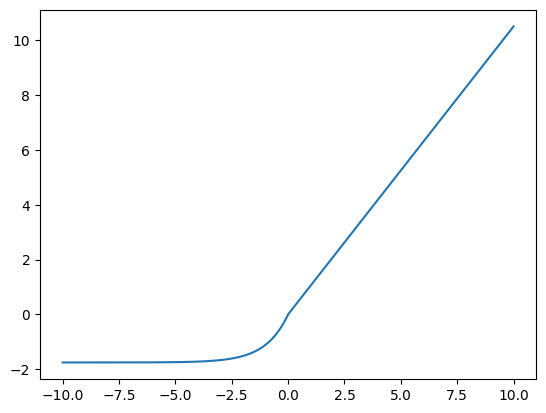

In [30]:
# Define a function
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda*jnp.where(x>0, x, alpha*jnp.exp(x)-alpha)

selu_jit = jit(selu) # Compiles the function

# Visualize selu
visualize_fn(selu)

Benchmark jit vs non-jit

In [32]:
data = jax.random.normal(key, (1000000,))

print("Non-jit Version")
%timeit selu(data).block_until_ready()

print("Jit Version")
%timeit selu_jit(data).block_until_ready()

Non-jit Version
2.19 ms ± 130 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Jit Version
527 μs ± 25.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
